# Import necessary libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE



# 1️⃣ Data Collection & Preprocessing

In [2]:

# Load dataset
file_path = "C:/Users/microtree/Downloads/loyaltyvisionanalytics/LoyaltyVision Analytics.xlsx"
df = pd.read_excel(file_path)

# Standardizing column names (removing spaces)
df.columns = df.columns.str.strip()

# Convert numeric fields stored as objects
numeric_cols = ['Tenure', 'City_Tier', 'CC_Contacted_LY', 'Service_Score', 'Account_user_count', 
                'CC_Agent_Score', 'rev_per_month', 'Complain_ly', 'rev_growth_yoy', 
                'coupon_used_for_payment', 'Day_Since_CC_connect', 'cashback']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing values
for col in df.columns:
    if df[col].dtype == 'object':  # Categorical columns
        df[col] = df[col].fillna(df[col].mode()[0])  
    else:  # Numerical columns
        df[col] = df[col].fillna(df[col].median())



In [3]:
# 2️⃣ Exploratory Data Analysis (EDA)

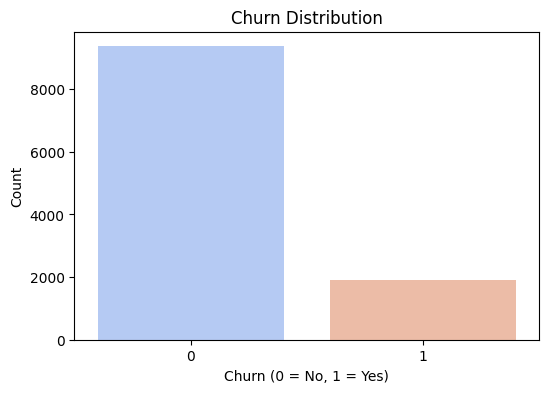

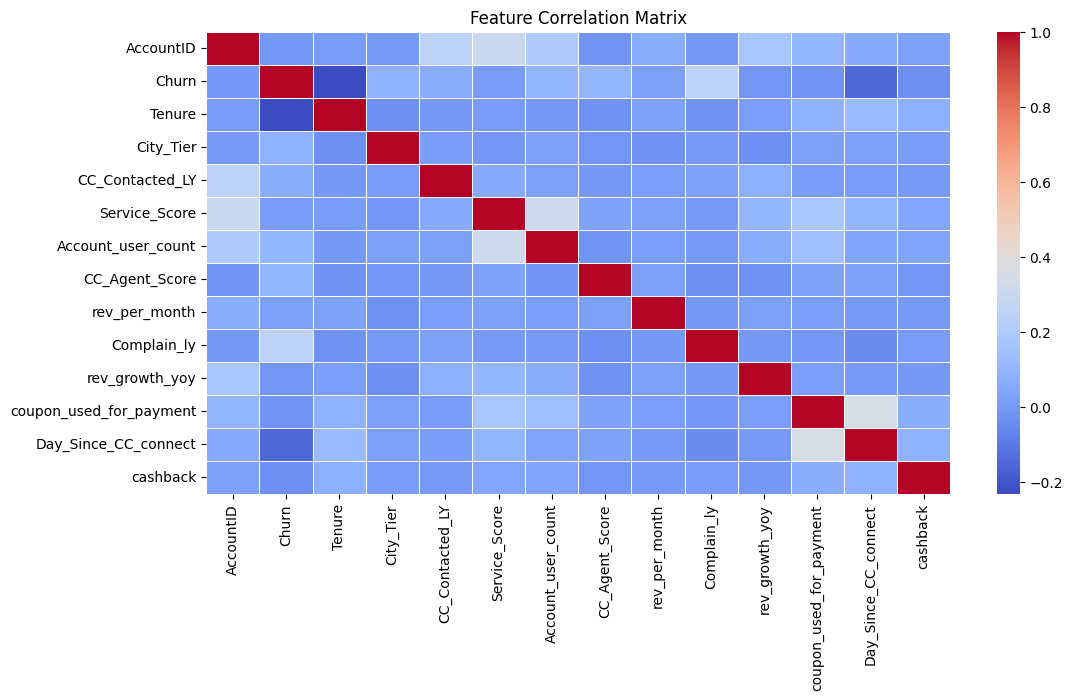

In [4]:

# Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Churn'], palette='coolwarm')
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# **Fix: Drop non-numeric columns before computing correlation**
df_numeric = df.select_dtypes(include=[np.number])

# Correlation Heatmap (Only Numeric Features)
plt.figure(figsize=(12, 6))
sns.heatmap(df_numeric.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()



# 3️⃣ Feature Engineering & Selection

In [5]:
# Create new meaningful features
df['avg_complaint_per_tenure'] = df['Complain_ly'] / (df['Tenure'] + 1)
df['revenue_per_user'] = df['rev_per_month'] / (df['Account_user_count'] + 1)
df['net_cashback'] = df['cashback'] - df['coupon_used_for_payment']
df['contact_to_tenure_ratio'] = df['CC_Contacted_LY'] / (df['Tenure'] + 1)

# Drop redundant features
df.drop(columns=['Complain_ly', 'cashback', 'coupon_used_for_payment'], inplace=True)

# Encoding categorical variables
binary_cols = ['Gender', 'Marital_Status']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

categorical_cols = ['Payment', 'account_segment', 'Login_device', 'City_Tier']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define features and target variable
X = df.drop(columns=['Churn'])
y = df['Churn']

# Handle Class Imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Scaling numerical features
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# 4️⃣ Machine Learning Model Development

In [6]:
# Define and train XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15],
    'min_child_weight': [1, 3, 5]
}

# Hyperparameter tuning
grid_search = RandomizedSearchCV(xgb, param_dist, cv=5, scoring='accuracy', n_iter=10, random_state=42)
grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_
print("\nBest Model Parameters:\n", grid_search.best_params_)

# Predictions
y_pred = best_xgb.predict(X_test)




Best Model Parameters:
 {'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.2}


# 5️⃣ Model Evaluation & Optimization


 Improved Model Accuracy: 0.9736654804270463

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1873
           1       0.98      0.94      0.96       937

    accuracy                           0.97      2810
   macro avg       0.97      0.97      0.97      2810
weighted avg       0.97      0.97      0.97      2810



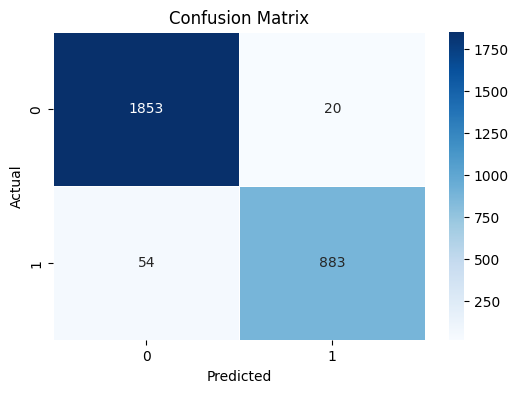

In [7]:
# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("\n Improved Model Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d', linewidths=0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



# 6️⃣ Implementation & Business Impact


🔹 High-Value Customers at Risk of Churning:
        rev_per_month  Tenure  Churn_Prob Risk_Category
0                9.0     4.0    0.983840          High
3                8.0     0.0    0.781095          High
18               2.0     0.0    0.998752          High
20               5.0     0.0    0.977688          High
23               4.0     0.0    0.979319          High
...              ...     ...         ...           ...
11246            3.0     9.0    0.998614          High
11249            8.0     3.0    0.963492          High
11253            3.0     5.0    0.852746          High
11255            9.0    10.0    0.898007          High
11257            7.0     1.0    0.989007          High

[1918 rows x 4 columns]


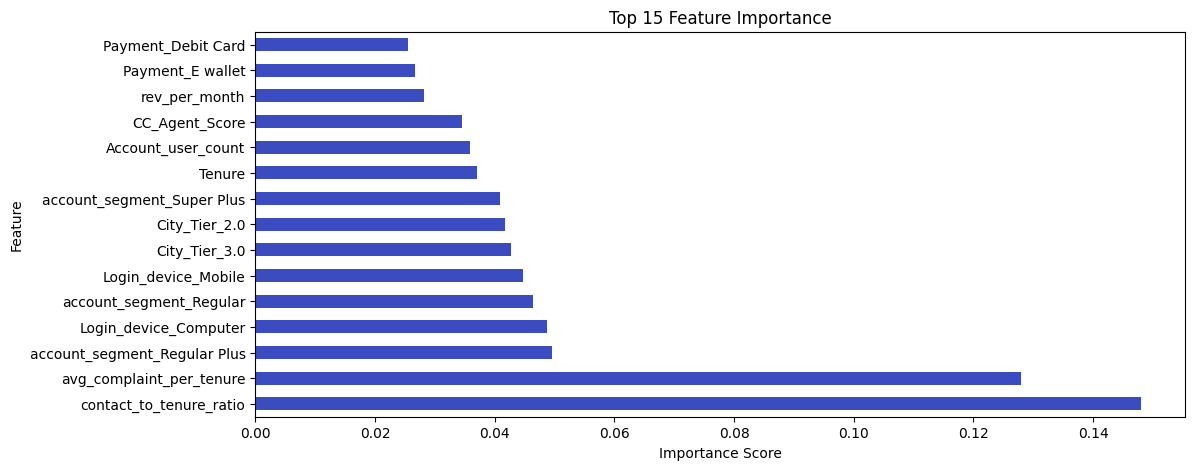

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


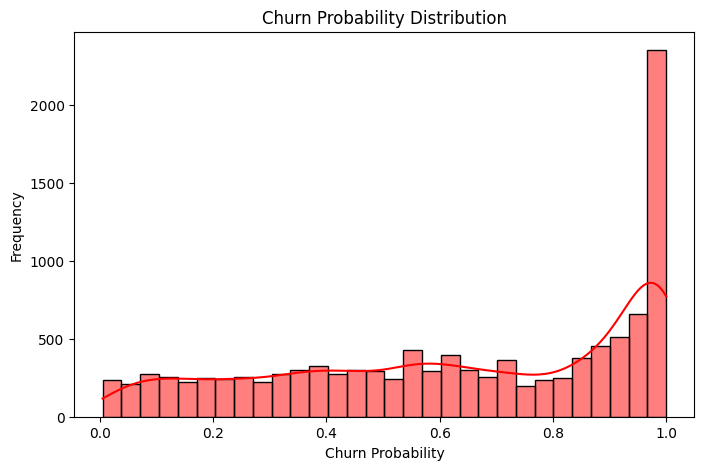

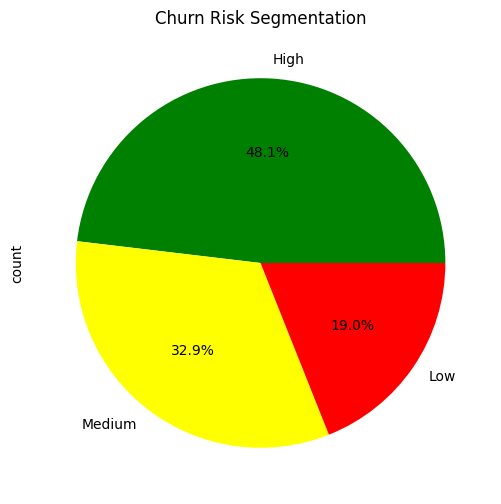

In [8]:
# Predict churn probability
df['Churn_Prob'] = best_xgb.predict_proba(X)[:, 1]

# Segment customers into risk categories
df['Risk_Category'] = pd.cut(df['Churn_Prob'], bins=[0, 0.3, 0.7, 1], labels=['Low', 'Medium', 'High'])

# High-value customers at risk
high_value_at_risk = df[(df['account_segment_Super'] == 1) & (df['Risk_Category'] == 'High')]
print("\n🔹 High-Value Customers at Risk of Churning:\n", high_value_at_risk[['rev_per_month', 'Tenure', 'Churn_Prob', 'Risk_Category']])

# Feature Importance Bar Graph
plt.figure(figsize=(12, 5))
feature_importance = pd.Series(best_xgb.feature_importances_, index=X.columns)
feature_importance.nlargest(15).plot(kind='barh', colormap="coolwarm")
plt.title("Top 15 Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Churn Probability Histogram
plt.figure(figsize=(8, 5))
sns.histplot(df['Churn_Prob'], bins=30, kde=True, color="red")
plt.title("Churn Probability Distribution")
plt.xlabel("Churn Probability")
plt.ylabel("Frequency")
plt.show()

# Churn Risk Segmentation Pie Chart
plt.figure(figsize=(6, 6))
df['Risk_Category'].value_counts().plot.pie(autopct='%1.1f%%', colors=['green', 'yellow', 'red'])
plt.title("Churn Risk Segmentation")
plt.show()
